<a href="https://colab.research.google.com/github/SuperCoolCucumber/CompLing/blob/main/RNN_homework8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание № 8

## Задание 1 (4 балла) 

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:  
1) модель с 1 GRU слоем;   
2) модель с 1 LSTM слоем    
3) модель с 1 GRU и 1 LSTM слоем  
4) модель с 1 BIGRU и 2 LSTM слоями  
5) модель с 5 GRU слоями и 3 LSTM слоями  
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались   
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM  



Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.nn.utils.rnn import pad_sequence

In [3]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/lenta_40k.csv.zip')

In [ ]:
data.dropna(subset=['topic', 'text'], inplace=True)

In [ ]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [ ]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [ ]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [ ]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, word2id, MAX_LEN, texts, targets):
        
        # храним сырой датасет
        # еще лучше можно сделать, если считывать из файла при генерации
        self.texts = [torch.LongTensor([word2id[w] for w in self.preprocess(t) if w in word2id][:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True)
        
        # мы не считаем словарь прямо тут, т.к. нам нужно шерить словарь между трейном и валидацией
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)
        # таргеты можно сразу целиком выделить 
        
        self.target = torch.LongTensor(targets)

    def __len__(self):
        # нужно уметь возвращать длину датасета, в нашем случае это просто сделать
        # если не загружать данные целиком, а читать из файла - это может быть сложнее
        return self.length

    def __getitem__(self, index):

        # в index будут индексы от 0 до self.length
        # по ним мы достанем тексты, предобработаем,переведем в векторы, западим и вернем

        ids = self.texts[index]
        y = self.target[index]

        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens


In [ ]:
MAX_LEN = 200

In [ ]:
texts = data.text.values
id2label = {i:l for i,l in enumerate(set(data.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.topic]

In [ ]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

In [ ]:
training_set = Dataset(word2id, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=256, shuffle=True, )

In [ ]:
valid_set = Dataset(word2id, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=256, shuffle=True)

In [ ]:
from sklearn.metrics import f1_score

def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze()  
        loss = criterion(predictions, ys.to(device))        
        
        
        
        loss.backward()
        optimizer.step()     
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))
        
        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')
        
    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   

            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions, ys.to(device))        
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
            

            epoch_loss.append(loss.item())  
            epoch_f1.append(f1_score(y_true, preds, average="micro"))
            
    return np.mean(epoch_f1)# / len(iterator)

In [ ]:
def plot_loss(f1s, f1s_eval):
    plt.plot(f1s)
    plt.plot(f1s_eval)
    plt.title('model f1')
    plt.ylabel('f1')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

### 1 GRU Layer

In [ ]:
class Clf_1(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.RNN_UNITS = 256
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        self.gru = nn.GRU(self.EMB_DIM, self.RNN_UNITS, batch_first=True)
        self.fc = nn.Linear(self.RNN_UNITS, output_dim)

        self.act = nn.LogSoftmax(1) 
       
        
    def forward(self, text):

        embedded = self.embedding(text)
        rnn_output, (h, *_) = self.gru(embedded)
        
        output = self.act(self.fc(h))        
        return output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf_1(len(label2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

0
Loss: 2.3483754062652586; F1 measure: 0.20703125
Eval -  0.30416666666666664
1
Loss: 1.824817259311676; F1 measure: 0.396484375
Eval -  0.5625510620915032
2
Loss: 1.1777021598815918; F1 measure: 0.6366796875
Eval -  0.6571844362745098
3
Loss: 0.8808860778808594; F1 measure: 0.7283203125
Eval -  0.6977890114379085
4
Loss: 0.6841877231001854; F1 measure: 0.78828125
Eval -  0.7166768790849674
5
Loss: 0.5281546059250831; F1 measure: 0.83546875
Eval -  0.723187295751634
6
Loss: 0.4043016880750656; F1 measure: 0.8739453125
Eval -  0.7262152777777778
7
Loss: 0.29217993065714837; F1 measure: 0.913359375
Eval -  0.7277726715686275
8
Loss: 0.200436427667737; F1 measure: 0.9437890625
Eval -  0.7131842320261438
9
Loss: 0.13914611332118512; F1 measure: 0.9630859375
Eval -  0.7216605392156863


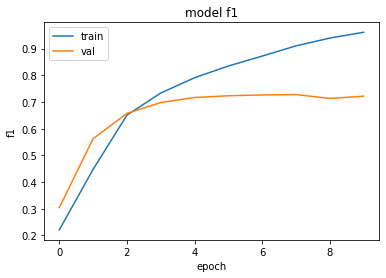

In [ ]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

plot_loss(f1s, f1s_eval)

Модель переобучилась 👎

### 1 LSTM Layer

In [ ]:
class Clf_2(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.RNN_UNITS = 256
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        self.lstm = nn.LSTM(self.EMB_DIM, self.RNN_UNITS, batch_first=True)
        self.fc = nn.Linear(self.RNN_UNITS, output_dim)

        self.act = nn.LogSoftmax(1) 
       
        
    def forward(self, text):
        embedded = self.embedding(text)
        rnn_output, (h, *_) = self.lstm(embedded)
        h = h.squeeze(0)
        output = self.act(self.fc(h))        
        return output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf_2(len(label2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

0
Loss: 2.35736398935318; F1 measure: 0.20796875
Eval -  0.2140625
1
Loss: 2.274958522319794; F1 measure: 0.2191796875
Eval -  0.21188214869281047
2
Loss: 2.1304773020744325; F1 measure: 0.2638671875
Eval -  0.35646956699346405
3
Loss: 1.80388449549675; F1 measure: 0.3864453125
Eval -  0.4014501633986928
4
Loss: 1.6130768489837646; F1 measure: 0.4621875
Eval -  0.506530841503268
5
Loss: 1.4001120734214783; F1 measure: 0.5519921875
Eval -  0.5445465686274509
6
Loss: 1.2413177514076232; F1 measure: 0.6108984375
Eval -  0.5777318218954248
7
Loss: 1.1188939040899277; F1 measure: 0.65109375
Eval -  0.5957363153594771
8
Loss: 0.9935687869787216; F1 measure: 0.695546875
Eval -  0.6209150326797386
9
Loss: 0.8497090196609497; F1 measure: 0.75375
Eval -  0.651108047385621


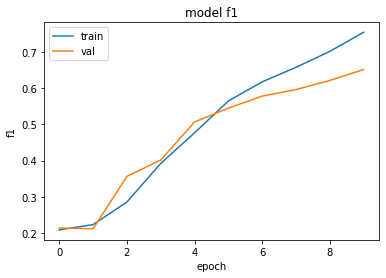

In [ ]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

plot_loss(f1s, f1s_eval)

Снова заметно переобучение, хотя F1 мера относительно неплохая.

### 1 GRU Layer and 1 LSTM Layer

In [ ]:
class Clf_3(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.RNN_UNITS = 256
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        
        self.gru = nn.GRU(self.EMB_DIM, self.RNN_UNITS, batch_first=True)
        self.lstm = nn.LSTM(self.RNN_UNITS, self.RNN_UNITS, batch_first=True)
        self.fc = nn.Linear(self.RNN_UNITS, output_dim)

        self.act = nn.LogSoftmax(1) 
       
        
    def forward(self, text):

        embedded = self.embedding(text)
        rnn_output, h = self.gru(embedded)
        rnn_output, (h, *_) = self.lstm(rnn_output)
        
        h = h.squeeze(0)
        
        output = self.act(self.fc(h))        
        return output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf_3(len(label2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

0
Loss: 2.3483956813812257; F1 measure: 0.20703125
Eval -  0.2965992647058824
1
Loss: 1.8973706340789795; F1 measure: 0.3516015625
Eval -  0.4218341503267974
2
Loss: 1.5835507535934448; F1 measure: 0.4769921875
Eval -  0.5514450571895425
3
Loss: 1.2299937558174134; F1 measure: 0.6166015625
Eval -  0.6290083741830066
4
Loss: 1.0114574044942857; F1 measure: 0.695625
Eval -  0.6424172794117646
5
Loss: 0.8582845216989518; F1 measure: 0.7452734375
Eval -  0.6639297385620915
6
Loss: 0.7201987820863723; F1 measure: 0.79
Eval -  0.6641186683006536
7
Loss: 0.5867089435458184; F1 measure: 0.83265625
Eval -  0.6623672385620915
8
Loss: 0.4757296150922775; F1 measure: 0.8695703125
Eval -  0.6830269607843138
9
Loss: 0.37784301817417143; F1 measure: 0.899296875
Eval -  0.6782271241830065


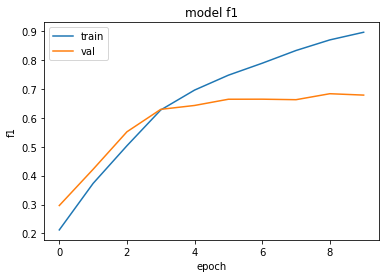

In [ ]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

plot_loss(f1s, f1s_eval)

Переобучение опять

### 1 BiGRU Layer and 2 LSTM Layers

In [ ]:
class Clf_4(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.RNN_UNITS = 256
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        
        self.gru = nn.GRU(self.EMB_DIM, self.RNN_UNITS, batch_first=True, bidirectional=True)
        self.lstm = nn.LSTM(self.RNN_UNITS * 2, self.RNN_UNITS, num_layers=2, batch_first=True)
        self.fc = nn.Linear(self.RNN_UNITS, output_dim)

        self.act = nn.LogSoftmax(1) 
       
        
    def forward(self, text):

        embedded = self.embedding(text)
        # embedded_backward = torch.flip(embedded, (1, ))

        rnn_output, h = self.gru(embedded)
        rnn_output, (h, *_) = self.lstm(rnn_output)
      
        h = h[-1]
        # h = h.squeeze(0)
        # h, h_backward = h.squeeze(0), h_backward.squeeze(0)
        
        output = self.act(self.fc(h))        
        return output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf_4(len(label2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

0
Loss: 2.345174939632416; F1 measure: 0.2030078125
Eval -  0.22233966503267974
1
Loss: 2.2028249073028565; F1 measure: 0.237421875
Eval -  0.32131331699346405
2
Loss: 1.9034745073318482; F1 measure: 0.3387890625
Eval -  0.4040492238562091
3
Loss: 1.7475880217552184; F1 measure: 0.4098046875
Eval -  0.4318270016339869
4
Loss: 1.6160474348068237; F1 measure: 0.4630078125
Eval -  0.4758833741830066
5
Loss: 1.4769693541526794; F1 measure: 0.5128125
Eval -  0.5414470996732026
6
Loss: 1.3054514527320862; F1 measure: 0.5813671875
Eval -  0.5913654003267974
7
Loss: 1.1496294003725052; F1 measure: 0.6459765625
Eval -  0.6150837418300654
8
Loss: 1.0511154490709305; F1 measure: 0.679375
Eval -  0.6497855392156863
9
Loss: 0.9032107567787171; F1 measure: 0.725703125
Eval -  0.6767361111111111


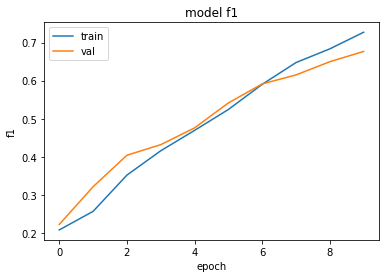

In [ ]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

plot_loss(f1s, f1s_eval)

Неплохой результат тут получился, модель не переобучилась, в отличие от остальных в этой домашке, и f1 мера тоже окей.

### 5 GRU Layers and 3 LSTM Layers

In [ ]:
class Clf_5(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.RNN_UNITS = 256
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        
        self.gru = nn.GRU(self.EMB_DIM, self.RNN_UNITS, num_layers=5, batch_first=True)
        self.lstm = nn.LSTM(self.RNN_UNITS, self.RNN_UNITS, num_layers=3, batch_first=True)
        self.fc = nn.Linear(self.RNN_UNITS, output_dim)

        self.act = nn.LogSoftmax(1) 
       
        
    def forward(self, text):

        embedded = self.embedding(text)
        rnn_output, h = self.gru(embedded)
        rnn_output, (h, *_) = self.lstm(rnn_output)
        
        
        # h = h.squeeze(0)
        h = h[-1]
        
        output = self.act(self.fc(h))        
        return output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf_5(len(label2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

0
Loss: 2.3558035588264463; F1 measure: 0.20484375
Eval -  0.2119076797385621
1
Loss: 2.3261216616630556; F1 measure: 0.215078125
Eval -  0.21059027777777778
2
Loss: 2.322651033401489; F1 measure: 0.213984375
Eval -  0.2123468137254902
3
Loss: 2.3236757707595825; F1 measure: 0.21421875
Eval -  0.21015114379084968
4
Loss: 2.321301214694977; F1 measure: 0.2144921875
Eval -  0.2099315767973856
5
Loss: 2.32089408159256; F1 measure: 0.218515625
Eval -  0.17216605392156864
6
Loss: 2.319032652378082; F1 measure: 0.2113671875
Eval -  0.21212724673202615
7
Loss: 2.319418816566467; F1 measure: 0.21984375
Eval -  0.21146854575163399
8
Loss: 2.3266319680213927; F1 measure: 0.2126171875
Eval -  0.21059027777777778
9
Loss: 2.324040288925171; F1 measure: 0.2150390625
Eval -  0.21102941176470588


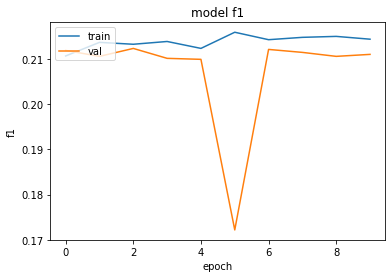

In [ ]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

plot_loss(f1s, f1s_eval)

Ээээээ... не

### 1 BIGRU Layer and 1 BILSTM Layer (different models for `forward` and `backward` propagation)

In [ ]:
class Clf_6(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.RNN_UNITS = 256
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        
        self.gru = nn.GRU(self.EMB_DIM, self.RNN_UNITS, batch_first=True, bidirectional=True)
        self.lstm = nn.LSTM(self.RNN_UNITS, self.RNN_UNITS, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(self.RNN_UNITS*2, output_dim)

        self.act = nn.LogSoftmax(1) 
       
        
    def forward(self, text):

        embedded = self.embedding(text)
        embedded_backward = torch.flip(embedded, (1,))

        gru_output, (h, _) = self.gru(embedded)
        gru_output_backward, (gru_h_backward, _) = self.gru(embedded_backward)

        h, gru_h_backward = h.squeeze(0), gru_h_backward.squeeze(0)

         h_concat = torch.cat([h, gru_h_backward], 1)

        
        output = self.act(self.fc(h_concat))        
        return output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf_6(len(label2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

0
Loss: 2.1837838542461396; F1 measure: 0.2934765625
Eval -  0.5599060457516339
1
Loss: 1.2944235515594482; F1 measure: 0.6060546875
Eval -  0.6454503676470588
2
Loss: 0.9625873374938965; F1 measure: 0.706875
Eval -  0.7175551470588235
3
Loss: 0.7579696434736252; F1 measure: 0.7638671875
Eval -  0.7420853758169934
4
Loss: 0.6003298357129097; F1 measure: 0.80875
Eval -  0.7568627450980392
5
Loss: 0.4786962988972664; F1 measure: 0.8481640625
Eval -  0.745547385620915
6
Loss: 0.3469715619087219; F1 measure: 0.8916796875
Eval -  0.7405535130718954
7
Loss: 0.23887377768754958; F1 measure: 0.92828125
Eval -  0.7505412581699347
8
Loss: 0.1574516749382019; F1 measure: 0.9550390625
Eval -  0.7397007761437908
9
Loss: 0.09649966787546874; F1 measure: 0.976015625
Eval -  0.7366523692810457


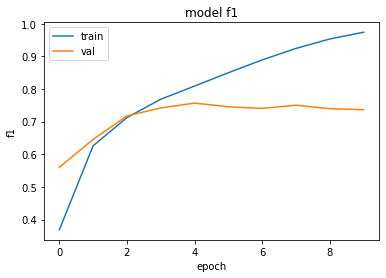

In [ ]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

plot_loss(f1s, f1s_eval)

I like my overfitting how I like my coffee -- bitter.

### Consecutive layers: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM

In [ ]:
class Clf_7(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.RNN_UNITS = 256
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        self.lstm_1 = nn.LSTM(self.EMB_DIM, self.RNN_UNITS, batch_first=True)
        self.gru_1 = nn.GRU(self.RNN_UNITS, self.RNN_UNITS, batch_first=True)
        self.bilstm = nn.LSTM(self.RNN_UNITS, self.RNN_UNITS, batch_first=True, bidirectional=True)
        self.bigru = nn.GRU(self.RNN_UNITS*2, self.RNN_UNITS*2, batch_first=True, bidirectional=True)
        self.gru_2 = nn.GRU(self.RNN_UNITS*4, self.RNN_UNITS*2, batch_first=True)
        self.lstm_2 = nn.LSTM(self.RNN_UNITS*2, self.RNN_UNITS, batch_first=True)


        self.fc = nn.Linear(self.RNN_UNITS, output_dim)

        self.act = nn.LogSoftmax(1) 
       
        
    def forward(self, text):

        embedded = self.embedding(text)
        rnn_output, (h, _) = self.lstm_1(embedded)
        rnn_output, h = self.gru_1(rnn_output)
        rnn_output, (h, _) = self.bilstm(rnn_output)
        rnn_output, (h, _) = self.bigru(rnn_output)
        rnn_output, h = self.gru_2(rnn_output)
        rnn_output, (h, _) = self.lstm_2(rnn_output)
        
        
        # h = h.squeeze(0)
        h = h[-1]
        
        output = self.act(self.fc(h))        
        return output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf_7(len(label2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

0
Loss: 2.339330153465271; F1 measure: 0.2063671875
Eval -  0.25531045751633985
1
Loss: 2.146424787044525; F1 measure: 0.269296875
Eval -  0.3059078839869281
2
Loss: 2.025320007801056; F1 measure: 0.3148046875
Eval -  0.369515931372549
3
Loss: 1.7575332498550416; F1 measure: 0.403984375
Eval -  0.48760723039215687
4
Loss: 1.4715081357955933; F1 measure: 0.52
Eval -  0.5709865196078431
5
Loss: 1.284907236099243; F1 measure: 0.5871484375
Eval -  0.6118208741830065
6
Loss: 1.1527072668075562; F1 measure: 0.63078125
Eval -  0.6231413398692811
7
Loss: 1.047612407207489; F1 measure: 0.6586328125
Eval -  0.6239481209150326
8
Loss: 0.9339974129199982; F1 measure: 0.6971484375
Eval -  0.6652113970588236
9
Loss: 0.8194198209047318; F1 measure: 0.745078125
Eval -  0.694092116013072


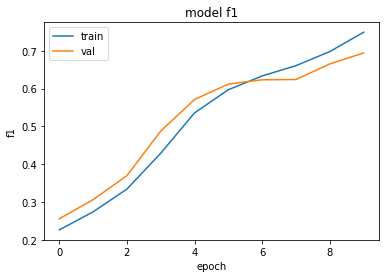

In [ ]:
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

plot_loss(f1s, f1s_eval)

Внезапно лучший результат получился здесь. Практически нет переобучения, и линия тренировочной выборки с валидационной довольно похожи. F1 мера тоже самая высокая здесь.

# ¯\ _ (ツ)_/¯

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите 2 модели:  
1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев. 
1) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев. 

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [4]:
pip install datasets

     |████████████████████████████████| 346 kB 25.0 MB/s 
     |████████████████████████████████| 140 kB 72.2 MB/s 
     |████████████████████████████████| 212 kB 62.4 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 1.1 MB 68.0 MB/s 
     |████████████████████████████████| 127 kB 75.4 MB/s 
     |████████████████████████████████| 271 kB 61.9 MB/s 
     |████████████████████████████████| 144 kB 72.2 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [5]:
from datasets import load_dataset

In [6]:
data = load_dataset('wikiann', 'ru')

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset wikiann downloaded and prepared to /root/.cache/huggingface/datasets/wikiann/ru/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
data

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 20000
    })
})

In [8]:
vocab = Counter()

for text in data['train']['tokens']:
    vocab.update([x.lower() for x in text])

for text in data['validation']['tokens']:
    vocab.update([x.lower() for x in text])

for text in data['test']['tokens']:
    vocab.update([x.lower() for x in text])

In [9]:
len(vocab)

59524

In [10]:
word2id = {'PAD':0}

for word in vocab:
    word2id[word] = len(word2id)

In [11]:
id2word = {i:word for word, i in word2id.items()}

In [12]:
tags = set()
for seq in data['train']['ner_tags']:
    tags.update(seq)

label2id = {'PAD':0}
for tag in tags:
    label2id[tag] = len(label2id)

    
id2label = {i:l for l, i in label2id.items()}
tags = [id2label[i] for i in range(len(label2id))]

In [13]:
MAX_LEN = max(len(s) for s in data['train']['tokens'])

In [14]:
MAX_LEN

54

In [15]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, word2id, label2id, MAX_LEN, texts, labels):
        
        self.texts = [torch.LongTensor([word2id[w.lower()] for w in t][:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True)
        self.targets = [torch.LongTensor([label2id[l] for l in seq][:MAX_LEN]) for seq in labels]
        self.targets = torch.nn.utils.rnn.pad_sequence(self.targets, batch_first=True)
        
        self.word2id = word2id
        self.label2id = label2id
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)
    
    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.targets[index]

        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens


In [16]:
BATCH_SIZE = 256

In [17]:
train_texts = data['train']['tokens']
valid_texts = data['validation']['tokens']
train_labels = data['train']['ner_tags']
valid_labels = data['validation']['ner_tags']

In [18]:
training_set = Dataset(word2id, label2id, MAX_LEN, train_texts, train_labels)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True, )

In [19]:
valid_set = Dataset(word2id, label2id, MAX_LEN, valid_texts, valid_labels)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)

In [24]:
def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = []
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device))
        loss = criterion(predictions.permute(0, 2, 1), ys.to(device))
        
        loss.backward()
        optimizer.step()     
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        
        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}')
        
    return np.mean(epoch_loss)


def evaluate(model, iterator, criterion):
    
    epoch_loss = []

    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   
            
            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions.permute(0, 2, 1), ys.to(device))        
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
          
            

            epoch_loss.append(loss.item())
            
    return np.mean(epoch_loss)
   

In [74]:
# функция для классификейшн репорта

def evaluate_(model, iterator):
    
    #epoch_loss = []
    preds_ = []
    y_true_ = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   
            
            predictions = model(texts.to(device)).squeeze()      
            preds = predictions.detach().to('cpu').exp().numpy().argmax(-1).tolist()
            y_true = ys.tolist()
            preds_.append(preds)
            y_true_.append(y_true)
            

    return preds_, y_true_

### Модель без предобученных эмбеддингов

In [26]:
class Clf_1(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.LSTM_UNITS = 128
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        self.rnn = nn.LSTM(self.EMB_DIM, self.LSTM_UNITS, num_layers=3, bidirectional=True,
                            batch_first=True) 

        
        self.fc = nn.Linear(self.LSTM_UNITS*2,output_dim)
        self.act = nn.LogSoftmax(2) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)
        rnn_output, (h, *_) = self.rnn(embedded)
        hidden = self.fc(rnn_output)
        outputs=self.act(hidden)

        return outputs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf_1(len(label2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [27]:
losses = []
losses_eval = []

for i in range(10):
    print(i)
    losses.append(train(model, training_generator, optimizer, criterion, 30))
    losses_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.5085907027125358
Loss: 0.35519709512591363
1
Loss: 0.15740079830090206
Loss: 0.14887315804759663
2
Loss: 0.1165227822959423
Loss: 0.11144593109687169
3
Loss: 0.08435073619087537
Loss: 0.08005057536065578
4
Loss: 0.0614657711237669
Loss: 0.05988193893184265
5
Loss: 0.048633808145920436
Loss: 0.04765169142434995
6
Loss: 0.03765592413643996
Loss: 0.0376977731163303
7
Loss: 0.030411065307756266
Loss: 0.029572005694111187
8
Loss: 0.02316584965835015
Loss: 0.023104074007521073
9
Loss: 0.017065872810781
Loss: 0.01717985641832153


In [76]:
preds, y_true = evaluate_(model, valid_generator)

In [77]:
from sklearn.metrics import classification_report

In [78]:
print(classification_report(np.vstack(y_true).reshape(-1), np.vstack(preds).reshape(-1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    469728
           1       0.93      0.93      0.93     39967
           2       0.84      0.80      0.82      3590
           3       0.89      0.88      0.89      7570
           4       0.62      0.64      0.63      3891
           5       0.72      0.79      0.75      7297
           6       0.73      0.72      0.72      4851
           7       0.76      0.67      0.71      3106

    accuracy                           0.98    540000
   macro avg       0.81      0.80      0.81    540000
weighted avg       0.98      0.98      0.98    540000



Получилось уже неплохо. Берем эмбеддинги.

In [80]:
pip install fasttext

     |████████████████████████████████| 68 kB 8.0 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3148409 sha256=f018e0f4e5990cf6ff939653331f80090343fce9dae0425ad700e3cda866d840
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [81]:
import fasttext.util

In [83]:
fasttext.util.download_model('ru')

'cc.ru.300.bin'

In [84]:
ft = fasttext.load_model('cc.ru.300.bin')

In [85]:
weights = np.zeros((len(word2id), 300))

for word, i in word2id.items():
    if word == 'PAD':
        continue
    
    try:
        weights[i] = ft.get_word_vector(word)
    
    
    except KeyError:
        weights[i] = ft.get_word_vector('опрагпллирао')

### Pretrained embeddings + 3 BILSTM Layers

In [86]:
class Clf_NER(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.LSTM_UNITS = 128
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.rnn = nn.LSTM(self.EMB_DIM, self.LSTM_UNITS, num_layers=3, bidirectional=True,
                            batch_first=True) 

        
        self.fc = nn.Linear(self.LSTM_UNITS*2,output_dim)
        self.act = nn.LogSoftmax(2) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)
        rnn_output, (h, *_) = self.rnn(embedded)
        hidden = self.fc(rnn_output)
        outputs=self.act(hidden)

        return outputs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf_NER(len(label2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [87]:
losses = []
losses_eval = []

for i in range(10):
    print(i)
    losses.append(train(model, training_generator, optimizer, criterion, 30))
    losses_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.5060306519269944
Loss: 0.35399831309914587
1
Loss: 0.15362345278263093
Loss: 0.14615263727804026
2
Loss: 0.11779039179285368
Loss: 0.1092203926295042
3
Loss: 0.08144937679171563
Loss: 0.07891586249073347
4
Loss: 0.062016659726699196
Loss: 0.06185525928934415
5
Loss: 0.05145336017012596
Loss: 0.04978426868716876
6
Loss: 0.04039431338508924
Loss: 0.0398798830807209
7
Loss: 0.03126350101083517
Loss: 0.031552460975944996
8
Loss: 0.02495182380080223
Loss: 0.02389958134541909
9
Loss: 0.018792898487299682
Loss: 0.018114553422977527


In [88]:
preds, y_true = evaluate_(model, valid_generator)

In [89]:
print(classification_report(np.vstack(y_true).reshape(-1), np.vstack(preds).reshape(-1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    469728
           1       0.93      0.93      0.93     39967
           2       0.86      0.81      0.83      3590
           3       0.91      0.88      0.90      7570
           4       0.66      0.59      0.62      3891
           5       0.75      0.76      0.75      7297
           6       0.68      0.77      0.72      4851
           7       0.69      0.71      0.70      3106

    accuracy                           0.98    540000
   macro avg       0.81      0.81      0.81    540000
weighted avg       0.98      0.98      0.98    540000



С эмбеддингами получилось чуть лучше, чем без них.

### Pretrained embeddings + 3 BIGRU Layers

In [90]:
class Clf_NER1(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 100
        self.RNN_UNITS = 128
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.rnn = nn.GRU(self.EMB_DIM, self.RNN_UNITS, num_layers=3, bidirectional=True,
                            batch_first=True) 

        
        self.fc = nn.Linear(self.RNN_UNITS*2,output_dim)
        self.act = nn.LogSoftmax(2) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)
        rnn_output, (h, *_) = self.rnn(embedded)
        hidden = self.fc(rnn_output)
        outputs=self.act(hidden)

        return outputs


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf_NER1(len(label2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [91]:
losses = []
losses_eval = []

for i in range(10):
    print(i)
    losses.append(train(model, training_generator, optimizer, criterion, 30))
    losses_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.3229008659720421
Loss: 0.23870091065764426
1
Loss: 0.12306731740633646
Loss: 0.11440419703722
2
Loss: 0.08614640310406685
Loss: 0.08148945445815722
3
Loss: 0.06278864219784737
Loss: 0.06271479601661364
4
Loss: 0.05155533278981845
Loss: 0.05009308755397797
5
Loss: 0.041873448093732196
Loss: 0.0405319563113153
6
Loss: 0.03323234456280867
Loss: 0.032257254763195915
7
Loss: 0.025202795242269833
Loss: 0.02470658269400398
8
Loss: 0.01992003063981732
Loss: 0.018954713456332685
9
Loss: 0.014051747974008322
Loss: 0.01399322496727109


In [92]:
preds, y_true = evaluate_(model, valid_generator)

In [93]:
print(classification_report(np.vstack(y_true).reshape(-1), np.vstack(preds).reshape(-1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    469728
           1       0.92      0.94      0.93     39967
           2       0.75      0.84      0.79      3590
           3       0.85      0.91      0.88      7570
           4       0.68      0.56      0.61      3891
           5       0.78      0.74      0.76      7297
           6       0.74      0.72      0.73      4851
           7       0.77      0.70      0.73      3106

    accuracy                           0.98    540000
   macro avg       0.81      0.80      0.80    540000
weighted avg       0.98      0.98      0.98    540000



Еще небольшое улучшение.